In [1]:
import pandas as pd
from datasets import Dataset, DatasetDict
import re

SEED = 42

In [2]:
df = pd.read_csv('../data/ELLIPSE_Full_manual_clean_finished_calculated.csv')

df.head(2)

,text_id,full_text,gender,grade,race_ethnicity,num_words,num_words2,num_words3,num_sent,num_para,...,task,SES,prompt,Overall,Cohesion,Syntax,Vocabulary,Phraseology,Grammar,Conventions
0,2021000501,"Dear, TEACHER_NAME\n\nI think phone policy at ...",Male,8,Hispanic/Latino,111,122,118,7,2,...,Independent,Economically disadvantaged,Cell phones at school,3.0,3.5,2.5,3.5,3.0,3.5,2.5
1,2021000535,"Dear, Principal\r\n\r\nIn my opinion, I think ...",Female,8,Hispanic/Latino,99,105,102,6,2,...,Independent,Economically disadvantaged,Cell phones at school,3.0,2.5,3.0,4.0,3.5,3.0,3.5


## Clean text

Collapse all contiguous spans of whitespace into a single space. Also removes leading and trailing whitespace.

Specific preprocessing steps are a matter of preference. Most transformers (especially newer, larger ones) were pretrained on diverse and messy text scraped from the internet.

In [19]:
df['clean_text'] = df.full_text.apply(lambda text: re.sub(r'\s+', r' ', text.strip()))
df.clean_text.sample(5)

215     For me the best Policy is the first one becaus...
1273    How can a students learn more from home than a...
2842    1. Many kinds can't understand because the dif...
1098    Imagine taking four-day school week and having...
6464    I disagree about what the principal has decide...
Name: clean_text, dtype: object

## We have some long texts

Most transformers have a maximum sequence length of 512 tokens. Transformer tokenizers do not operate at the word level. Many words will be split into "sub-word tokens". This means a typical transformer can handle roughly ~400 words.

For this showcase, we will simply truncate texts that are too long, but there are models that can handle longer sequence lengths (e.g., Longformer). There are also approaches for handling longer sequences with standard pretrained models, such as using a "sliding window" approach. We truncate in the interest of simplicity.

<Axes: >

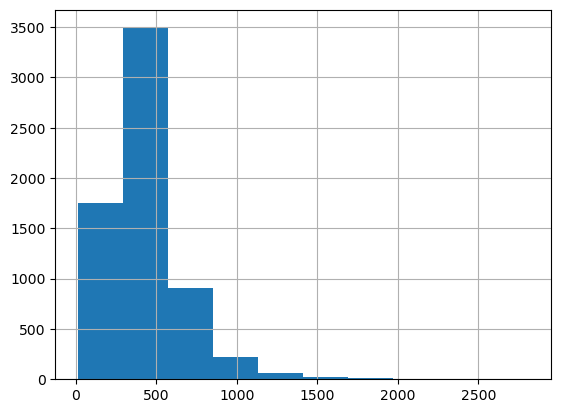

In [25]:
df.num_words.hist()

### Truncation

To see how many texts will be truncated and what will be lost, we need to use the transformer's tokenization scheme.

We will be developing models from `bert-base-uncased`, so we need to import its `sentencepiece` tokenizer. This will produce a warning, since we set `truncation=False` (which is the default value).

In [23]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def tokenize(text):
    input_ids = tokenizer(text, truncation=False)['input_ids']
    return input_ids

input_ids = df.clean_text.apply(tokenize)

Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors


The following functions count the number of tokens in each sample.

Around 40% of our samples will be truncated. When we evaluate our model, we will report how this affects performance.

<Axes: >

count    6482.000000
mean      489.050139
std       216.793364
min        16.000000
50%       457.000000
55%       480.000000
60%       506.000000
65%       531.000000
70%       564.000000
75%       599.000000
80%       637.000000
max      1527.000000
Name: clean_text, dtype: float64

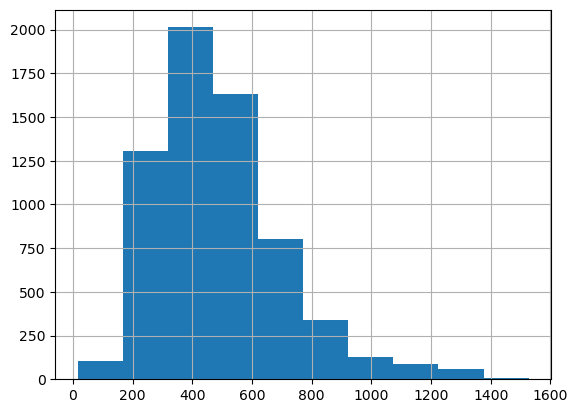

In [24]:
import numpy as np
input_ids.str.len().describe(percentiles=np.arange(.5, .8, step=.05))

display(input_ids.str.len().hist())

## Build Dataset

Create a DatasetDict that will hold the dataset partitions. Saving this to disk promotes reproducibility by guaranteeing that different scripts are accessing the same data splits. I find that it also helps to organize our research code.

It is possible to tokenize at this stage, but I prefer to tokenize at the last minute. This affords us the flexibility of changing tokenization schemes, which could be useful if we want to test different pretrained models (that may use different tokenizers).

In [16]:
def build_dataset(df):
    
    columns = ['text_id',
               'clean_text',
               'Overall',
               'Cohesion',
               'Syntax',
               'Vocabulary',
               'Phraseology',
               'Grammar',
               'Conventions']
    
    df = df[columns].rename(columns = {'clean_text': 'text'})
    
    ds = Dataset.from_pandas(df, preserve_index=False)
    
    # 70% train, 15% development, 15% test
    train_remains = ds.train_test_split(test_size=0.3, seed=SEED)
    train = train_remains['train']
    _remains = train_remains['test']
    
    dev_test = _remains.train_test_split(test_size=0.5, seed=SEED)
    dev = dev_test['train']
    test = dev_test['test']
    
    dd = DatasetDict({
        'train': train,
        'dev': dev, 
        'test': test})

    return dd

In [17]:
dd = build_dataset(df)

In [15]:
dd.save_to_disk('../data/ellipse.hf')

Saving the dataset (0/1 shards):   0%|          | 0/4537 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/972 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/973 [00:00<?, ? examples/s]